## Import all libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import product
from tqdm import tqdm, tqdm_notebook
import sklearn
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
from xgboost import XGBRegressor
import gc



## Downcast function(source-ensembling notebook)

In [2]:
def downcast_dtypes(df):    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

## Import all datasets for EDA

In [3]:
sales = pd.read_csv('E:/datasets/sales_train.csv')
shops = pd.read_csv('E:/datasets/shops.csv')
items = pd.read_csv('E:/datasets/items.csv')
item_cats = pd.read_csv('E:/datasets/item_categories.csv')
test= pd.read_csv('E:/datasets/test.csv')
sample_submission = pd.read_csv('E:/datasets/sample_submission.csv')


# EDA

Let's take a look at our training data set

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Let's check out the number of NaN's or any columns with zero or close to zero variance in train data

In [5]:
print(sales.isnull().sum())
sales.std()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


date_block_num       9.422988
shop_id             16.226973
item_id           6324.297354
item_price        1729.799631
item_cnt_day         2.618834
dtype: float64

There are no null values in the dataset and no columns which seem to be almost constant.
Now let's check out the item_price column of sales_train

In [6]:
sum(sales.item_price == -1)

1

I had a doubt whether they masked NAs with -1. It only made sense that this number be in the item_price category as only for this column, it doesn't make sense for a value of -1(Which item would be placed at a cost of -1)

Now we know that there is only 1 row with an item_price value of -1 so I believe it's safe to ignore.

Now let's see a histogram of how many items there are per category

<BarContainer object of 84 artists>

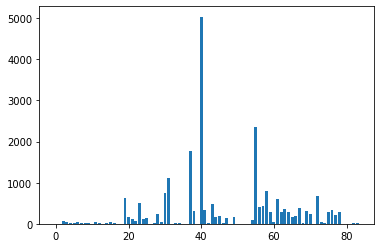

In [7]:
%matplotlib inline

items_per_cat = items.item_category_id.value_counts()
plt.bar(items_per_cat.index, items_per_cat.values)

We see several spikes but we can see that one spike is clearly visible and has the highest value.
Let's check out which category this is and how many items there are in this category.

We see that it is item category no. 40 and it has 5035 items.

In [8]:
items_per_cat.iloc[items_per_cat.values == items_per_cat.values.max()]

40    5035
Name: item_category_id, dtype: int64

Now we have to predict how much the shops will sell in the month of November 2015. 

Let's now analyze how much items are sold monthly from January 2013 to October 2015.

c:\users\govind\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='date_block_num'>

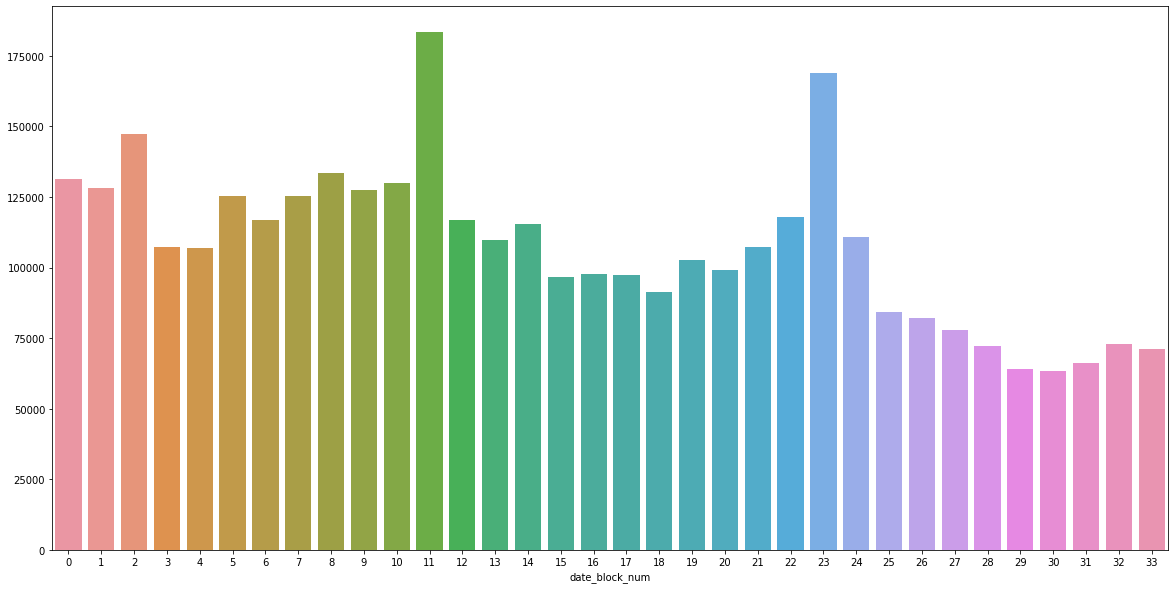

In [9]:
plt.figure(figsize=(20,10))
sales_per_month = sales.groupby('date_block_num')['item_cnt_day'].sum()
sns.barplot(sales_per_month.index, sales_per_month.values)


We kind of see a trend here, the graph goes up and comes down(well, sort of).

We can see 3 clear spikes here for the months-2, 11 and 23

These months correspond to March 2013, December 2013 and December 2014.
We can explain the spike in the graph in December(Christmas season) but I really don't know why there is a spike only for March 2013. Also we dont see a spike in the values of March for other years compared to previous month sales.Maybe the shops decided to put a sale on items or maybe because of the stock market in that period.

# Feature Preprocessing

Now that we have taken a look at data, It is now time to generate features/Preprocess existing features. Since I am going to apply only 2 initial models(Linear regression and lightgbm). I must generate features accordingly for these 2 models itself. I will use a meta model of XGBoost for final predictions.

This code below creates the final data set to be used for training lightGBM and Linear Regression models.

In [10]:
test['date_block_num'] = [34 for _ in range(test.shape[0])]
test = test.drop("ID", axis=1)
#merge train and test
sales = sales.append(test, ignore_index=True)
#merging items dataset as it may contain some useful info
sales = pd.merge(sales, items, on = "item_id", how="left")
index_cols = ['shop_id', 'item_id', 'date_block_num']

In [11]:
#removing item_name and date
sales = sales.drop(['date', 'item_name'],axis=1)

In [12]:
#fill all the NaN values with -1
sales = sales.fillna(-1)
sales.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,59,22154,999.00,1.0,37
1,0,25,2552,899.00,1.0,58
2,0,25,2552,899.00,-1.0,58
3,0,25,2554,1709.05,1.0,58
4,0,25,2555,1099.00,1.0,56


In [13]:
#Let's now create the feature matrix
from itertools import product
matrix=[]
for i in range(35):
    sales_temp = sales[sales.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales_temp.shop_id.unique(), sales_temp.item_id.unique() ) ), dtype = np.int32) )



In [14]:
matrix = pd.DataFrame(np.vstack(matrix), columns = ["date_block_num", "shop_id", "item_id"])
matrix.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [15]:
"finding no. of sales per month for every shop and item combination"

item_cnt_month = sales.groupby(["date_block_num", "shop_id", "item_id"]).agg({"item_cnt_day":"sum"})
item_cnt_month.columns = ['item_cnt_month']
matrix = pd.merge(matrix, item_cnt_month, on = ["date_block_num", "shop_id", "item_id"], how="left").fillna(-999)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,59,22154,1.0
1,0,59,2552,-999.0
2,0,59,2554,-999.0
3,0,59,2555,-999.0
4,0,59,2564,-999.0


In [16]:
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, item_cats, on = ["item_category_id"], how = "left" )

In [17]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,item_name,item_category_id,item_category_name
0,0,59,22154,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,0,59,2552,-999.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,0,59,2554,-999.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,0,59,2555,-999.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,0,59,2564,-999.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео


In [18]:
#We are not gonna need shop_name, item_name and item_category_name columns so let's drop those
matrix= matrix.drop(["shop_name", "item_name", "item_category_name"], axis=1)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id
0,0,59,22154,1.0,37
1,0,59,2552,-999.0,58
2,0,59,2554,-999.0,58
3,0,59,2555,-999.0,56
4,0,59,2564,-999.0,59


Here we create a time based lag in the feature matrix

In [19]:
# credits to Ananya K for this code
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df


In [20]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,59,22154,1.0,37,NaN,NaN,NaN,NaN,NaN
1,0,59,2552,-999.0,58,NaN,NaN,NaN,NaN,NaN
2,0,59,2554,-999.0,58,NaN,NaN,NaN,NaN,NaN
3,0,59,2555,-999.0,56,NaN,NaN,NaN,NaN,NaN
4,0,59,2564,-999.0,59,NaN,NaN,NaN,NaN,NaN


Here we add some mean encoded features along with lags

In [21]:
def create_mean_encoded_col(df, target, cols,lags, new_col_name):
    temp = df.groupby(cols).agg({target:['mean']})
    temp.columns = [new_col_name]
    temp.reset_index(inplace = True)
    df = pd.merge(df, temp, on=cols, how="left")
    df = lag_feature(df, [1], new_col_name)
    df.drop(new_col_name, axis=1, inplace=True)
    return df

In [22]:
#mean_encoding based on date_block_num
matrix = create_mean_encoded_col(matrix, 'item_cnt_month', ['date_block_num'], [1], 'date_avg_item_cnt')
#mean encoding based on date_block_num and item_id 
matrix = create_mean_encoded_col(matrix, 'item_cnt_month',['date_block_num', 'item_id'], [1,2,3,6,12] , 'date_item_avg_item_cnt')
#mean encoding based on date_block_num and shop_id
matrix = create_mean_encoded_col(matrix, 'item_cnt_month',['date_block_num', 'shop_id'], [1,2,3,6,12] , 'date_shop_avg_item_cnt')
#mean encoding based on date_block_num, item_category_id
matrix = create_mean_encoded_col(matrix, 'item_cnt_month',['date_block_num', 'item_category_id'], [1] , 'date_shop_avg_item_cnt')
#mean encoding based on date_block_num, shop_id, item_category_id
matrix = create_mean_encoded_col(matrix, 'item_cnt_month',['date_block_num', 'shop_id', 'item_category_id'], [1,2,3,6,12] , 'date_shop_avg_item_cnt')

In [23]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_1_x,date_shop_avg_item_cnt_lag_1_y,date_shop_avg_item_cnt_lag_1
0,0,59,22154,1.0,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,59,2552,-999.0,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59,2554,-999.0,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,59,2555,-999.0,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,59,2564,-999.0,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


At first glance it seems that there are mostly NaNs only in the new columns we created but it is actually not so, there are normal values as well, although I still am not able to figure why NaNs arise(must be due to lags). A message in the comments would be helpful.

Months less than 12 are not useful here so let's just remove them and apply PCA for more feature extraction and dimensionality reduction.(One of the many methods used in Advanced Features 2 class). We will do this only for linear model.

In [24]:
matrix = matrix.loc[matrix['date_block_num'] >= 12]
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_1_x,date_shop_avg_item_cnt_lag_1_y,date_shop_avg_item_cnt_lag_1
4488756,12,54,10297,4.0,37,3.0,-999.0,NaN,NaN,NaN,-828.67577,-433.434783,-625.988317,-855.783337,-715.438919
4488757,12,54,10296,3.0,38,-999.0,NaN,NaN,NaN,NaN,-828.67577,-585.847826,-625.988317,-846.378475,-687.284153
4488758,12,54,10298,14.0,40,21.0,119.0,7.0,NaN,NaN,-828.67577,-57.130435,-625.988317,-860.006248,-661.239184
4488759,12,54,10300,3.0,37,1.0,31.0,-999.0,NaN,NaN,-828.67577,-476.608696,-625.988317,-855.783337,-715.438919
4488760,12,54,10284,1.0,57,-999.0,-999.0,-999.0,1.0,NaN,-828.67577,-912.043478,-625.988317,-904.235928,-641.758929


There are still a lot of NaNs so let's fill them up with -999(I am not much of a data science expert but I do believe NaNs should be filled with an outlier value so as to differentiate them).

In [25]:
matrix.fillna(-999, inplace= True)

Since we have to predict for the last month, We will divide the dataset into three parts:- training, validation and testing.

For test set, I will choose date_block_num to be 34.

For validation, I will select a random number in date_block_num(between 31-33). The dataset with date_block_num equal to that particular number will be our validation set and the remaining our train set.

In [26]:
import random 
test_num = 34
matrix_test = matrix.loc[matrix.date_block_num == test_num]
matrix_remaining = matrix.loc[matrix.date_block_num != test_num]
valid_num = random.randint(31,34)
matrix_valid = matrix_remaining.loc[matrix_remaining.date_block_num==valid_num]
matrix_train = matrix_remaining.loc[matrix_remaining.date_block_num!=valid_num]
del matrix_remaining

In [27]:
x_train = matrix_train.drop(['item_cnt_month'], axis=1)
x_valid = matrix_valid.drop(['item_cnt_month'], axis=1)
x_test = matrix_test.drop(['item_cnt_month'], axis=1)
y_train = matrix_train['item_cnt_month']
y_valid = matrix_valid['item_cnt_month']
y_test = matrix_test['item_cnt_month']

In [28]:
from sklearn.decomposition import PCA
pca = PCA(0.95, n_components=2)


In [29]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_train_scaled = mms.fit_transform(x_train)
x_valid_scaled = mms.fit_transform(x_valid)
x_test_scaled = mms.fit_transform(x_test)
x_train_pca = pca.fit_transform(x_train_scaled)
x_valid_pca = pca.transform(x_valid_scaled)
x_test_pca = pca.transform(x_test_scaled)

## Linear model

We use a pca preprocessing for linear model which we also scale(Non tree based models depend hugely on scaling)

In [30]:
lr = LinearRegression()
lr.fit(x_train_pca, y_train)
predLinear = lr.predict(x_test_pca).clip(0,20)
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': predLinear})
submission['item_cnt_month'].unique()
submission.to_csv("linear_model_submission.csv",  index=False)

## LightGBM

In [31]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(x_train, label=y_train), 100)
pred_lgb = model.predict(x_test.values).clip(0,20)
submission_lightgbm = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lgb})
submission_lightgbm.to_csv("lightgbm_model_submission.csv",  index=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.435608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


## XGBoost

In [32]:
xgb = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    tree_method='gpu_hist',
    seed=42)

xgb.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=False, 
    early_stopping_rounds = 20)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=0, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=0.5, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

In [33]:
pred_xgb = xgb.predict(x_test).clip(0,20)
submission_xgb = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_xgb})
submission_xgb.to_csv("submission_xgb.csv", index=False)

Now let's train try to get the validation data for the meta-model(KNN)

We are going to implement scheme a from 2nd-level validation schemes(simple holdout)
Although it makes more sense to use scheme f(time-based kfold scheme), I simply dont have enough computing resources.
(It took me 1 hour for each kfold).


In [59]:
part_a_train = x_train.iloc[0:2062307]
part_a_test = y_train.iloc[0:2062307]
part_b_train = x_train.iloc[2062308:4124614]
part_b_test = y_train.iloc[2062308:4124614]
part_c_train = x_train.iloc[4124614:x_train.shape[0]]
part_c_test = y_train.iloc[4124614:x_train.shape[0]]

In [60]:
lr.fit(part_a_train, part_a_test)
part_b_meta_lr = lr.predict(part_b_train)
part_c_meta_lr = lr.predict(part_c_train)

In [61]:
model = lgb.train(lgb_params, lgb.Dataset(part_a_train, label=part_a_test), 50)
part_b_meta_lgb = model.predict(part_b_train)
part_c_meta_lgb = model.predict(part_c_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [62]:
xgbr = XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xgbr.fit(part_a_train, part_a_test)
part_b_meta_xgb = xgb.predict(part_b_train)
part_c_meta_xgb = xgb.predict(part_c_train)

[22:06:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[22:06:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


In [63]:
test_meta_lr = lr.predict(x_test)
test_meta_lgb = model.predict(x_test)
test_meta_xgb = xgb.predict(x_test)

In [64]:
part_b_meta = pd.DataFrame({"lr" : part_b_meta_lr, "lgb":part_b_meta_lgb, "xgb":part_b_meta_xgb, "target":part_b_test})
part_c_meta = pd.DataFrame({"lr" : part_c_meta_lr, "lgb":part_c_meta_lgb, "xgb":part_c_meta_xgb, "target":part_c_test})
test_meta = pd.DataFrame({"lr" : test_meta_lr, "lgb":test_meta_lgb, "xgb":test_meta_xgb})

The scheme asks us to tune hyperparamets for meta model by training on part_b_meta and validating on part_c_meta. It is a lengthy trial and error process which I have already done in a different dataset. Below code only features the final model.

In [65]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(weights = "distance", leaf_size=100,n_jobs=-1)

In [68]:
meta_train = part_b_meta.drop("target",axis=1).append(part_c_meta.drop("target",axis=1), ignore_index=True)
meta_test = part_b_meta['target'].append(part_c_meta['target'])

In [73]:
knn.fit(meta_train, meta_test)
final_submission=knn.predict(test_meta).clip(0,20)

In [77]:
#final_submission = pd.DataFrame({"ID":sample_submission.ID, "item_cnt_month":final_submission})


ValueError: Shape of passed values is (2, 2), indices imply (214200, 2)